In [1]:
"""
The purpose of this Jupyter notebook is to ...
"""

'\nThe purpose of this Jupyter notebook is to ...\n'

In [1]:
import os
import math
from collections import defaultdict

import pandas as pd
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

#### Determining the Intersection Between the Screen Subset and the<br>Test Set

In [2]:
# Load the Dharmacon pooled subset of the screen
# As IQM normalization turned out to result in the strongest
# normalization, the corresponding TSV file is loaded
path_to_subset_tsv_file = (
    "Dharmacon_pooled_G1_G2_screening_plates_subset_with_missing_"
    "UniProt_IDs_IQM_normalized.tsv"
)

dp_g1_g2_subset_df = pd.read_csv(
    path_to_subset_tsv_file,
    sep="\t"
)

# Some rows do not have any UniProt accessions, be it because they are
# pseudogenes or because the NCBI Entrez data does not list any genes
# for the corresponding genes
# Remove these rows
dp_g1_g2_subset_df = dp_g1_g2_subset_df[
    ~dp_g1_g2_subset_df["UniProt_IDs"].isna()
]

In [3]:
# Determine the unique human UniProt accessions in the subset
human_uniprot_accs_in_subset_list = dp_g1_g2_subset_df[
    "UniProt_IDs"
].drop_duplicates().dropna().to_list()

# Bear in mind that many entries are composite entries with semicolons
# as separator
# Intermediate conversion to a set removes potential duplicates
human_uniprot_accs_in_subset_list = list(set([
    uniprot_acc
    for entry in human_uniprot_accs_in_subset_list
    for uniprot_acc in entry.split(";")
]))

In [4]:
# The evaluation is supposed to be confined to the test set
# Load the test set TSV file
path_to_test_set = (
    "/Users/jacobanter/Documents/Code/VACV_screen/HVIDB_pos_instances_"
    "with_nucleolus_neg_instances/new_combined_data_set_creation/"
    "data_set_files/bullet-proof_test_set.tsv"
)

test_set_df = pd.read_csv(
    path_to_test_set,
    sep="\t"
)

In [5]:
# Extract the unique human UniProt accessions from the test set
human_uniprot_accs_in_test_set_list = test_set_df[
    "Human_prot"
].drop_duplicates().to_list()

In [6]:
# Determine the intersection between the human proteins in the subset
# and the human proteins in the test set
intersection_subset_test_set = set.intersection(
    set(human_uniprot_accs_in_subset_list),
    set(human_uniprot_accs_in_test_set_list)
)

In [7]:
print(
    "Number of common proteins shared between the screen subset\nand "
    f"the test set: {len(intersection_subset_test_set):,}"
)

Number of common proteins shared between the screen subset
and the test set: 62


In [8]:
# Also determine the number of genes corresponding to these 62 human
# proteins
# To this end, a dictionary is generated mapping UniProt accessions to
# gene names
gene_name_uniprot_id_df = dp_g1_g2_subset_df[["Name", "UniProt_IDs"]].dropna()

gene_name_uniprot_id_df.loc[:, "UniProt_IDs"] = gene_name_uniprot_id_df[
    "UniProt_IDs"
].map(lambda x: x.split(";"))

gene_name_uniprot_id_df = gene_name_uniprot_id_df.explode("UniProt_IDs")

gene_name_uniprot_id_df.set_index("UniProt_IDs", inplace=True)

uniprot_acc_to_gene_name_dict = gene_name_uniprot_id_df["Name"].to_dict()

In [9]:
involved_genes = []

for common_uniprot_acc in intersection_subset_test_set:
    gene_name = uniprot_acc_to_gene_name_dict[common_uniprot_acc]
    if gene_name not in involved_genes:
        involved_genes.append(gene_name)

In [10]:
print(
    "The 62 common proteins shared between the screen subset and the "
    f"test set are\nencoded by {len(involved_genes):,} genes."
)

The 62 common proteins shared between the screen subset and the test set are
encoded by 47 genes.


In [11]:
# As it turns out, the number of genes is lower than the number of
# proteins, which implies that some proteins are encoded by the same
# gene
# As a next step, investigate whether proteins encoded by the same gene
# have the same label (i.e. 1 for a positive PPI and 0 for a negative
# PPI)

# First, gather UniProt accessions for all proteins encoded by the same
# gene
# To this end, the advantages of the `defaultdict` class are capitalized
# on
gene_name_to_uniprot_acc_list_dict = defaultdict(list)

for common_uniprot_acc in intersection_subset_test_set:
    gene_name = uniprot_acc_to_gene_name_dict[common_uniprot_acc]
    gene_name_to_uniprot_acc_list_dict[gene_name].append(
        common_uniprot_acc
    )

In [12]:
# Generate yet another dictionary mapping gene names to the labels of
# the corresponding UniProt accessions
gene_name_to_prot_label_dict = {}

for gene_name, uniprot_accs in gene_name_to_uniprot_acc_list_dict.items():
    # Retrieve the labels for the UniProt accessions in the current list
    # To this end, the test set DataFrame has to be sliced accordingly
    labels_for_gene_name = []

    for uniprot_acc in uniprot_accs:
        labels_for_uniprot_acc = test_set_df.loc[
            test_set_df["Human_prot"] == uniprot_acc,
            "label"
        ].drop_duplicates().to_list()
        
        labels_for_gene_name += labels_for_uniprot_acc
    
    # Intermediate conversion to a set removes possible duplicates
    labels_for_gene_name = list(set(labels_for_gene_name))
    
    gene_name_to_prot_label_dict[gene_name] = labels_for_gene_name

In [13]:
# Ideally, each gene has only one PPI label
# It is investigated whether this indeed is the case
one_ppi_label_per_gene_list = [
    len(label_list) == 1
    for _, label_list in gene_name_to_prot_label_dict.items()
]

assert all(one_ppi_label_per_gene_list), (
    "Not all genes have only one PPI label!"
)

In [14]:
# As it turns out, all genes have only one PPI label
# Extract the individual labels from the lists
gene_name_to_prot_label_dict = {
    gene_name: label_list[0]
    for gene_name, label_list in gene_name_to_prot_label_dict.items()
}

In [15]:
# Convert the dictionary `gene_name_to_prot_label_dict` into a Pandas
# DataFrame
# However, instead of directly passing the dictionary to
# `pd.DataFrame()`, the dictioary keys and values are extracted so that
# they occupy one column each
prot_label_data = {
    "Gene": list(gene_name_to_prot_label_dict.keys()),
    "Label": list(gene_name_to_prot_label_dict.values())
}

prot_label_df = pd.DataFrame(data=prot_label_data)

In [16]:
# Add the corresponding UniProt accessions to the DataFrame via a merge
# operation
# To this end, a step done earlier is repeated, which consists of
# creating a DataFrame mapping gene names to a list of proteins encoded
# by them
all_gene_names_to_uniprot_ids_df = dp_g1_g2_subset_df[[
    "Name", "UniProt_IDs"
]].dropna().drop_duplicates()

all_gene_names_to_uniprot_ids_df.loc[:, "UniProt_IDs"] = (
    all_gene_names_to_uniprot_ids_df["UniProt_IDs"]
    .map(lambda x: x.split(";"))
)

In [17]:
# Perform the merge operation
prot_label_df = prot_label_df.merge(
    all_gene_names_to_uniprot_ids_df,
    left_on="Gene",
    right_on="Name",
    how="left"
)

In [18]:
# Remove the `Name` column
prot_label_df.drop(
    labels="Name",
    axis=1,
    inplace=True
)

In [19]:
# Currently, the `UniProt_IDs` column has lists as its entries
# Use the `.explode()` method so that the column has individual UniProt
# accessions as its entries
# Furthermore, create a MultiIndex involving `Gene` as well as
# `UniProt_IDs`
prot_label_df = (
    prot_label_df
    .explode("UniProt_IDs")
    .set_index(["Gene", "UniProt_IDs"])
)

In [20]:
# Note that not all UniProt accessions that have been added by the merge
# operation are part of the intersection
# Thus, a filtering step must be applied
# Remember that the intersection between the test set and the screen
# subset is stored in the variable `intersection_subset_test_set`
prot_label_df = prot_label_df[
    prot_label_df
    .index
    .get_level_values("UniProt_IDs")
    .isin(intersection_subset_test_set)
]

In [21]:
# Verify that the filtering step was successful
assert len(prot_label_df) == 62, (
    "Something went wrong during the filtering step!"
)

In [22]:
# Create a directory related to ROC curve generation and save the
# DataFrame in that directory
roc_curve_dir_name = "roc_curves_and_related_data"

if not os.path.exists(roc_curve_dir_name):
    os.makedirs(roc_curve_dir_name)

In [24]:
prot_label_df.to_csv(
    os.path.join(
        roc_curve_dir_name,
        "gene_and_protein_labels.tsv"
    ),
    sep="\t",
    index=True
)

#### Saving the Intersection to a File

In [25]:
# Repeat a step done earlier, which consists of creating a DataFrame
# mapping gene names to a list of proteins encoded by them
all_gene_names_to_uniprot_ids_df = dp_g1_g2_subset_df[[
    "Name", "UniProt_IDs"
]].dropna().drop_duplicates()

all_gene_names_to_uniprot_ids_df.loc[:, "UniProt_IDs"] = (
    all_gene_names_to_uniprot_ids_df["UniProt_IDs"]
    .map(lambda x: x.split(";"))
)

In [26]:
# Filter this DataFrame to contain exclusively genes occurring in the
# intersection
intersection_gene_names_to_uniprot_ids_df = all_gene_names_to_uniprot_ids_df[
    all_gene_names_to_uniprot_ids_df["Name"].isin(involved_genes)
]

In [27]:
assert len(intersection_gene_names_to_uniprot_ids_df) == 47, (
    "The DataFrame does not contain the expected number of genes!"
)

In [143]:
# Save the resulting DataFrame to a TSV file
intersection_gene_names_to_uniprot_ids_df.to_csv(
    "genes_to_uniprot_ids_test_set_intersection.tsv",
    sep="\t",
    index=False
)

#### Stitching Together the PPI Prediction Chunks

In [15]:
# As a preliminary step, the five different PPI prediction chunks are
# stitched together
ppi_pred_chunk_dir = "Predictions"

ppi_pred_chunks_list = []
ppi_pred_chunks_len_list = []

for i in range(4):
    path_to_current_chunk = os.path.join(
        ppi_pred_chunk_dir,
        "xCAPT5_interaction_probs_Dharmacon_pooled_subset_with_440_"
        f"VACV_WR_prots_chunk_{i}_with_XGBoost_no_fitting.tsv"
    )
    current_chunk_df = pd.read_csv(
        path_to_current_chunk,
        sep="\t"
    )
    ppi_pred_chunks_list.append(current_chunk_df)
    ppi_pred_chunks_len_list.append(len(current_chunk_df))

missing_ppi_preds_file_name = (
    "xCAPT5_interaction_probs_missing_human_prots_from_combined_data_"
    "set_with_440_VACV_WR_prots_with_XGBoost_no_fitting.tsv"
)
missing_ppi_preds_path = os.path.join(
    ppi_pred_chunk_dir,
    missing_ppi_preds_file_name
)

missing_ppi_preds_df = pd.read_csv(
    missing_ppi_preds_path,
    sep="\t"
)

ppi_pred_chunks_list.append(missing_ppi_preds_df)
ppi_pred_chunks_len_list.append(len(missing_ppi_preds_df))

In [16]:
all_ppi_preds_df = pd.concat(ppi_pred_chunks_list)

assert (
    len(all_ppi_preds_df)
    ==
    sum(ppi_pred_chunks_len_list)
), (
    "Something went wrong while stitching the PPI prediction\nchunks "
    "together!"
)

In [17]:
# Finally, save the stitched PPI prediction DataFrame to a TSV file
all_ppi_preds_df.to_csv(
    os.path.join(
        ppi_pred_chunk_dir,
        "xCAPT5_interaction_probs_Dharmacon_pooled_subset_with_440_"
        "VACV_WR_prots_all_PPIs.tsv"
    ),
    sep="\t",
    index=False
)

#### Intensity Refinement via Predicted PPI Probabilities

In [23]:
# Now that these preliminary investigations have been completed, turn to
# the screen read-out refinement, i.e. the refinement of the
# IQM-normalized intensities
# Investigate the number of times each gene is interrogated in the
# screen subset
# Remember to exclude control wells while doing so
gene_counts = dp_g1_g2_subset_df.loc[
    dp_g1_g2_subset_df["WellType"] == "POOLED_SIRNA",
    "Name"
].value_counts().drop_duplicates().astype(str).to_list()

In [24]:
print(
    "The genes interrogated in the screen subset occur the following "
    f"numbers\nof times: {', '.join(gene_counts)}"
)

The genes interrogated in the screen subset occur the following numbers
of times: 8, 6, 4, 2


In [25]:
# The approach is as follows:
# For each gene, the mean intensity is computed for each IQM-normalized
# intensity measurement (Cells, Nuclei, PeriNuclei and VoronoiCells)
# Using these unrefined mean intensities, ROC curves are generated as
# they summarize a classifier's performance across different
# classification thresholds
# Subsequently, the mean intensities are refined in different ways:
# The first refinement method involves multiplication of the intensity
# by the maximum predicted PPI probability (bear in mind that for each
# human protein, PPIs are predicted for all 440 VACV WR proteins)
# The second refinement method consists of multiplication by the mean
# predicted probability
# The third refinement method multiplies the intensity by the sum of
# the predicted PPI probabilities
# ...
# In all three cases, multiplication is followed by conversion of the
# values to a [0, 1] range
# The same procedure is performed for the raw, i.e. unnormalized
# intensity values

##### Computing Summary Statistics for Predicted PPI Probabilities

In [26]:
# Create a directory for storing the refined intensities and related
# files
refined_int_dir_name = "refined_intensities_and_related_data"

if not os.path.exists(refined_int_dir_name):
    os.makedirs(refined_int_dir_name)

In [27]:
# Load the TSV file comprising all PPI predictions
path_to_all_ppi_preds_tsv = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_"
    "Dharmacon_pooled_genome_1_and_2_subset/Predictions/xCAPT5_"
    "interaction_probs_Dharmacon_pooled_subset_with_440_VACV_WR_prots_"
    "all_PPIs.tsv"
)

all_ppi_preds_df = pd.read_csv(
    path_to_all_ppi_preds_tsv,
    sep="\t"
)

In [28]:
# In the TSV file comprising all PPI predictions, for each human
# protein, PPI probabilities are given for all 440 VACV proteins
# Quickly verify whether this indeed is the case
# Human UniProt accessions are stored in the first column bearing the
# name `protein_1`
n_ppis_per_human_prot = all_ppi_preds_df[
    "protein_1"
].value_counts().to_numpy()

assert all([
    n_ppis == 440
    for n_ppis in n_ppis_per_human_prot
]), (
    "Not all human proteins have PPI probabilities for all 400 VACV WR "
    "proteins!"
)

In [29]:
# Now, create a TSV file listing for each human protein the maximum, the
# mean, the median and the sum of the predicted PPI probabilities
ppi_prob_summary_df = (
    all_ppi_preds_df
    .groupby("protein_1")["interaction_probability"]
    .agg(
        max="max",
        mean="mean",
        median="median",
        sum="sum"
    )
)

In [30]:
# Rename the index name
ppi_prob_summary_df.index.name = "human_prot"

In [152]:
# Save the DataFrame with the summary statistics to a TSV file
ppi_prob_summary_df.to_csv(
   os.path.join(
       refined_int_dir_name,
       "PPI_probabilities_summary_statistics.tsv"
   ),
   sep="\t",
   index=True
)

##### Computing Mean Intensities for Normalized Intensity Measurements

In [24]:
# Perform a sanity check: It is planned to use the UniProt accessions as
# index in the intensities DataFrame
# To this end, it is investigated whether each UniProt accession is
# assigned to exclusively one gene
uniprot_acc_lists = (
    dp_g1_g2_subset_df["UniProt_IDs"]
    .dropna()
    .drop_duplicates()
    .map(lambda x: x.split(";"))
    .to_list()
)

In [20]:
n_prots_prior_to_duplicate_removal = sum(map(len, uniprot_acc_lists))

# Use a nested list comprehension to flatten the list of lists
flattened_uniprot_accs_list = [
    uniprot_acc
    for sublist in uniprot_acc_lists
    for uniprot_acc in sublist
]

n_prots_after_duplicate_removal = len(set(flattened_uniprot_accs_list))

assert (
    n_prots_prior_to_duplicate_removal
    ==
    n_prots_after_duplicate_removal
), (
    "There indeed are proteins assigned to more than one gene!\nIn "
    "detail, duplicate removal reduces the number of UniProt "
    f"accessions\nfrom {n_prots_prior_to_duplicate_removal:,} to "
    f"{n_prots_after_duplicate_removal:,}."
)

AssertionError: There indeed are proteins assigned to more than one gene!
In detail, duplicate removal reduces the number of UniProt accessions
from 44,082 to 43,767.

In [59]:
# As it turns out, there indeed are proteins assigned to more than one
# gene
# This, however, is not immediately relevant; instead, the refinement is
# just continued
# Compute the mean normalized intensity per measurement type for each
# group, i.e. each gene
mean_normalized_intensities_df = (
    dp_g1_g2_subset_df[
        dp_g1_g2_subset_df["WellType"] == "POOLED_SIRNA"
    ][[
        "Name",
        "dIntensity_cPathogen_eMean_oCells_nZScore",
        "dIntensity_cPathogen_eMean_oNuclei_nZScore",
        "dIntensity_cPathogen_eMean_oPeriNuclei_nZScore",
        "dIntensity_cPathogen_eMean_oVoronoiCells_nZScore",
        "dIntensity_cLatePathogen_eMean_oCells_nZScore",
        "dIntensity_cLatePathogen_eMean_oNuclei_nZScore",
        "dIntensity_cLatePathogen_eMean_oPeriNuclei_nZScore",
        "dIntensity_cLatePathogen_eMean_oVoronoiCells_nZScore"
    ]]
    .dropna()
    .set_index("Name")
    .groupby(level="Name")
    .mean()
    .reset_index()
)

In [60]:
# Thus far, the DataFrame only contains a column for the gene
# information ("Name"), but none for the UniProt accession information
# Add the UniProt accession information via a merge operation
mean_normalized_intensities_df = mean_normalized_intensities_df.merge(
    all_gene_names_to_uniprot_ids_df,
    left_on="Name",
    right_on="Name",
    how="left"
)

In [61]:
# The newly added `UniProt_IDs` column storing the UniProt accession
# information has lists as its entries
# In order to have individual UniProt accessions as entries, the Pandas
# `.explode()` method is utilized
mean_normalized_intensities_df = (
    mean_normalized_intensities_df
    .explode("UniProt_IDs")
    .set_index(["Name", "UniProt_IDs"])
)

##### Performing the Refinement for IQM-Normalized Intensity Values

In [25]:
# Load the summary statistics TSV file into a DataFrame
path_to_summary_statistics_tsv_file = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/refined_intensities_and_related_data/"
    "PPI_probabilities_summary_statistics.tsv"
)

ppi_prob_summary_stats_df = pd.read_csv(
    path_to_summary_statistics_tsv_file,
    sep="\t",
    index_col="human_prot"
)

In [27]:
# Now, the arguably most convenient way of performing the refinement
# (multiplication by maximum, mean, etc.) consists of extracting the
# refinement factors in the order of the UniProt accessions in
# `mean_normalized_intensities_df` and to simply perform the
# multiplication using Pandas vectorization
max_refinement_factors = (
    ppi_prob_summary_stats_df["max"].loc[
        mean_normalized_intensities_df.index.get_level_values("UniProt_IDs")
    ]
    .to_numpy()
)

In [30]:
# Finally, perform the multiplication with the maximum probability
# In order to ensure that multiplication is performed in a row-wise
# manner, the `.mul()` method is used in conjunction with the `axis`
# parameter
max_refined_normalized_intensities_df = mean_normalized_intensities_df.mul(
    max_refinement_factors,
    axis=0
)

In [41]:
# Now, convert the refined intensities to a [0, 1] range
# This is accomplished by means of min-max normalization, which uses the
# following formula: (x - x_{min}) / (x_{max} - x_{min})
# Min-max normalization is supposed to be applied for each column
# individually
# Conveniently enough, Pandas's `.min()` and `.max()` methods operate on
# a per column basis by default, so no special measures must be taken to
# ensure column-wise normalization
max_refined_normalized_intensities_df = (
    (
        max_refined_normalized_intensities_df
        -
        max_refined_normalized_intensities_df.min()
    )
    /
    (
        max_refined_normalized_intensities_df.max()
        -
        max_refined_normalized_intensities_df.min()
    )
)

In [43]:
# Save the DataFrame to a TSV file
max_refined_normalized_intensities_df.to_csv(
    os.path.join(
        refined_int_dir_name,
        "IQM-normalized_intensities_max_refined.tsv"
    ),
    sep="\t",
    index=True
)

In [26]:
# For the sake of convenience, define a function bundling the steps of
# refinement multiplication, min-max normalization and file saving under
# the hood
def refine_intensities(
        intensity_df, summary_stats_df, refinement_mode, output_path
):
    """
    Refines the intensities stored in `intensity_df` using the summary
    statistics deposited in `summary_stats_df` and saves the resulting
    DataFrame at the location specified by `output_path`.

    `intensity_df` is expected to have a MultiIndex with two levels. One
    level is expected to store gene names, whereas the second level
    should store UniProt accessions. The level storing UniProt
    accessions must bear the name "UniProt_IDs".

    `summary_stats_df` is expected to contain four columns, which are
    `max`, `mean`, `median` as well as `sum`. Its index is expected to
    consist of UniProt accessions.

    Accordingly, four different summary statistics can be used for the
    first step, i.e. the refinement step, which are "max", "mean",
    "median" and "sum". The summary statistics to use is specified by
    passing the corresponding string as argument to `refinement_mode`.

    The second step, i.e. the min-max normalization, is performed for
    each column in `intensity_df` individually, i.e. the minimum and
    maximum values are determined for each column separately and also
    exclusively applied to the respective column. Conveniently enough,
    Pandas's `.min()` and `.max()` methods operate on a per column basis
    by default, so no special measures must be taken to ensure
    column-wise normalization.

    Parameters
    ----------
    intensity_df: Pandas DataFrame
        Pandas DataFrame containing the intensity data to perform the
        refinement and normalization on.
    summary_stats_df: Pandas DataFrame
        Pandas DataFrame listing for each UniProt accessions the
        maximum, the mean, the median and the sum of the predicted PPI
        probabilities.
    refinement_mode: str
        A string denoting which of the summary statistics to use for the
        refinement (maximum, mean, median or sum).
    output_path: str
        A string denoting the location to save the resulting DataFrame
        at.

    Returns
    -------
    refined_intensity_df: Pandas DataFrame
        DataFrame containing the refined and normalized intensities.
    """
    
    # Extract the UniProt accessions from the MultiIndex in
    # `intensity_df`
    # This is necessary for the extraction of the refinement factors
    # (summary statistics stored in `summary_stats_df`)
    uniprot_accs = intensity_df.index.get_level_values("UniProt_IDs")

    refinement_factors = summary_stats_df[refinement_mode].loc[
        uniprot_accs
    ].to_numpy()

    # Perform the first step, i.e. the multiplication by the refinement
    # factors
    # In order to ensure that multiplication is performed in a row-wise
    # manner, the `.mul()` method is used in conjunction with the `axis`
    # parameter
    refined_intensity_df = intensity_df.mul(
        refinement_factors,
        axis=0
    )

    # Now, address the second step, i.e. the conversion of the refined
    # intensities to a [0, 1] range
    # This is accomplished by means of min-max normalization, which uses
    # the following formula: (x - x_{min}) / (x_{max} - x_{min})
    # Min-max normalization is supposed to be applied for each column
    # individually
    # Conveniently enough, Pandas's `.min()` and `.max()` methods
    # operate on a per column basis by default, so no special measures
    # must be taken to ensure column-wise normalization
    refined_intensity_df = (
        (refined_intensity_df - refined_intensity_df.min())
        /
        (refined_intensity_df.max() - refined_intensity_df.min())
    )

    # Save the DataFrame to a TSV file at the location specified by
    # `output_path`
    refined_intensity_df.to_csv(
        output_path,
        sep="\t",
        index=True
    )

    return refined_intensity_df

In [64]:
# Use the function to perform the refinement for the remaining
# refinement modes

# Using the mean predicted probability as refinement factor
refine_intensities(
    mean_normalized_intensities_df,
    ppi_prob_summary_stats_df,
    "mean",
    os.path.join(
        refined_int_dir_name,
        "IQM-normalized_intensities_mean_refined.tsv"
    )
)

dIntensity_cPathogen_eMean_oCells_nZScore  \
Name   UniProt_IDs                                              
A1BG   P04217                                        0.462347   
       V9HWD8                                        0.462347   
A1CF   B4E1E3                                        0.144180   
       F8W9F8                                        0.138268   
       Q9NQ94                                        0.161790   
...                                                       ...   
ZYG11B Q9C0D3                                        0.289005   
ZYX    H0Y2Y8                                        0.409244   
       Q15942                                        0.413012   
ZZEF1  O43149                                        0.298136   
ZZZ3   Q8IYH5                                        0.391358   

                    dIntensity_cPathogen_eMean_oNuclei_nZScore  \
Name   UniProt_IDs                                               
A1BG   P04217                                         0.428436   
       V9HWD8                                         0.428436   
A1CF   B4E1E3                                         0.138006   
       F8W9F8                                         0.132366   
       Q9NQ94                                         0.154807   
...                                                        ...   
ZYG11B Q9C0D3                                         0.252773   
ZYX    H0Y2Y8                                         0.346353   
       Q15942                                         0.349547   
ZZEF1  O43149                                         0.278341   
ZZZ3   Q8IYH5                                         0.362434   

                    dIntensity_cPathogen_eMean_oPeriNuclei_nZScore  \
Name   UniProt_IDs                                                   
A1BG   P04217                                             0.492968   
       V9HWD8                                             0.492968   
A1CF   B4E1E3                                             0.160382   
       F8W9F8                                             0.153822   
       Q9NQ94                                             0.179923   
...                                                            ...   
ZYG11B Q9C0D3                                             0.297855   
ZYX    H0Y2Y8                                             0.398781   
       Q15942                                             0.402460   
ZZEF1  O43149                                             0.324477   
ZZZ3   Q8IYH5                                             0.409722   

                    dIntensity_cPathogen_eMean_oVoronoiCells_nZScore  \
Name   UniProt_IDs                                                     
A1BG   P04217                                               0.592312   
       V9HWD8                                               0.592312   
A1CF   B4E1E3                                               0.194691   
       F8W9F8                                               0.186724   
       Q9NQ94                                               0.218422   
...                                                              ...   
ZYG11B Q9C0D3                                               0.363910   
ZYX    H0Y2Y8                                               0.477203   
       Q15942                                               0.481607   
ZZEF1  O43149                                               0.396220   
ZZZ3   Q8IYH5                                               0.486481   

                    dIntensity_cLatePathogen_eMean_oCells_nZScore  \
Name   UniProt_IDs                                                  
A1BG   P04217                                            0.403276   
       V9HWD8                                            0.403276   
A1CF   B4E1E3                                            0.134499   
       F8W9F8                                            0.128993   
       Q9NQ94                                        

In [65]:
# Using the median predicted probability as refinement factor
refine_intensities(
    mean_normalized_intensities_df,
    ppi_prob_summary_stats_df,
    "median",
    os.path.join(
        refined_int_dir_name,
        "IQM-normalized_intensities_median_refined.tsv"
    )
)

dIntensity_cPathogen_eMean_oCells_nZScore  \
Name   UniProt_IDs                                              
A1BG   P04217                                        0.456566   
       V9HWD8                                        0.456566   
A1CF   B4E1E3                                        0.128921   
       F8W9F8                                        0.111813   
       Q9NQ94                                        0.158037   
...                                                       ...   
ZYG11B Q9C0D3                                        0.274355   
ZYX    H0Y2Y8                                        0.367359   
       Q15942                                        0.382018   
ZZEF1  O43149                                        0.274083   
ZZZ3   Q8IYH5                                        0.380365   

                    dIntensity_cPathogen_eMean_oNuclei_nZScore  \
Name   UniProt_IDs                                               
A1BG   P04217                                         0.423275   
       V9HWD8                                         0.423275   
A1CF   B4E1E3                                         0.123514   
       F8W9F8                                         0.107190   
       Q9NQ94                                         0.151294   
...                                                        ...   
ZYG11B Q9C0D3                                         0.240299   
ZYX    H0Y2Y8                                         0.311311   
       Q15942                                         0.323737   
ZZEF1  O43149                                         0.256059   
ZZZ3   Q8IYH5                                         0.352448   

                    dIntensity_cPathogen_eMean_oPeriNuclei_nZScore  \
Name   UniProt_IDs                                                   
A1BG   P04217                                             0.486895   
       V9HWD8                                             0.486895   
A1CF   B4E1E3                                             0.143607   
       F8W9F8                                             0.124634   
       Q9NQ94                                             0.175895   
...                                                            ...   
ZYG11B Q9C0D3                                             0.283083   
ZYX    H0Y2Y8                                             0.358372   
       Q15942                                             0.372677   
ZZEF1  O43149                                             0.298450   
ZZZ3   Q8IYH5                                             0.398423   

                    dIntensity_cPathogen_eMean_oVoronoiCells_nZScore  \
Name   UniProt_IDs                                                     
A1BG   P04217                                               0.584584   
       V9HWD8                                               0.584584   
A1CF   B4E1E3                                               0.174230   
       F8W9F8                                               0.151213   
       Q9NQ94                                               0.213403   
...                                                              ...   
ZYG11B Q9C0D3                                               0.345578   
ZYX    H0Y2Y8                                               0.428562   
       Q15942                                               0.445671   
ZZEF1  O43149                                               0.364138   
ZZZ3   Q8IYH5                                               0.472790   

                    dIntensity_cLatePathogen_eMean_oCells_nZScore  \
Name   UniProt_IDs                                                  
A1BG   P04217                                            0.411437   
       V9HWD8                                            0.411437   
A1CF   B4E1E3                                            0.124555   
       F8W9F8                                            0.108120   
       Q9NQ94                                        

In [66]:
# Using the sum of the predicted probabilities as refinement factor
refine_intensities(
    mean_normalized_intensities_df,
    ppi_prob_summary_stats_df,
    "sum",
    os.path.join(
        refined_int_dir_name,
        "IQM-normalized_intensities_sum_refined.tsv"
    )
)

dIntensity_cPathogen_eMean_oCells_nZScore  \
Name   UniProt_IDs                                              
A1BG   P04217                                        0.462347   
       V9HWD8                                        0.462347   
A1CF   B4E1E3                                        0.144180   
       F8W9F8                                        0.138268   
       Q9NQ94                                        0.161790   
...                                                       ...   
ZYG11B Q9C0D3                                        0.289005   
ZYX    H0Y2Y8                                        0.409244   
       Q15942                                        0.413012   
ZZEF1  O43149                                        0.298136   
ZZZ3   Q8IYH5                                        0.391358   

                    dIntensity_cPathogen_eMean_oNuclei_nZScore  \
Name   UniProt_IDs                                               
A1BG   P04217                                         0.428436   
       V9HWD8                                         0.428436   
A1CF   B4E1E3                                         0.138006   
       F8W9F8                                         0.132366   
       Q9NQ94                                         0.154807   
...                                                        ...   
ZYG11B Q9C0D3                                         0.252773   
ZYX    H0Y2Y8                                         0.346353   
       Q15942                                         0.349547   
ZZEF1  O43149                                         0.278341   
ZZZ3   Q8IYH5                                         0.362434   

                    dIntensity_cPathogen_eMean_oPeriNuclei_nZScore  \
Name   UniProt_IDs                                                   
A1BG   P04217                                             0.492968   
       V9HWD8                                             0.492968   
A1CF   B4E1E3                                             0.160382   
       F8W9F8                                             0.153822   
       Q9NQ94                                             0.179923   
...                                                            ...   
ZYG11B Q9C0D3                                             0.297855   
ZYX    H0Y2Y8                                             0.398781   
       Q15942                                             0.402460   
ZZEF1  O43149                                             0.324477   
ZZZ3   Q8IYH5                                             0.409722   

                    dIntensity_cPathogen_eMean_oVoronoiCells_nZScore  \
Name   UniProt_IDs                                                     
A1BG   P04217                                               0.592312   
       V9HWD8                                               0.592312   
A1CF   B4E1E3                                               0.194691   
       F8W9F8                                               0.186724   
       Q9NQ94                                               0.218422   
...                                                              ...   
ZYG11B Q9C0D3                                               0.363910   
ZYX    H0Y2Y8                                               0.477203   
       Q15942                                               0.481607   
ZZEF1  O43149                                               0.396220   
ZZZ3   Q8IYH5                                               0.486481   

                    dIntensity_cLatePathogen_eMean_oCells_nZScore  \
Name   UniProt_IDs                                                  
A1BG   P04217                                            0.403276   
       V9HWD8                                            0.403276   
A1CF   B4E1E3                                            0.134499   
       F8W9F8                                            0.128993   
       Q9NQ94                                        

##### Performing the Refinement for Raw Intensity Values

In [27]:
# Perform the same procedure for the raw, i.e. unnormalized intensities
mean_raw_intensities_df = (
    dp_g1_g2_subset_df[
        dp_g1_g2_subset_df["WellType"] == "POOLED_SIRNA"
    ][[
        "Name",
        "dIntensity_cPathogen_eMean_oCells",
        "dIntensity_cPathogen_eMean_oNuclei",
        "dIntensity_cPathogen_eMean_oPeriNuclei",
        "dIntensity_cPathogen_eMean_oVoronoiCells",
        "dIntensity_cLatePathogen_eMean_oCells",
        "dIntensity_cLatePathogen_eMean_oNuclei",
        "dIntensity_cLatePathogen_eMean_oPeriNuclei",
        "dIntensity_cLatePathogen_eMean_oVoronoiCells"
    ]]
    .dropna()
    .set_index("Name")
    .groupby(level="Name")
    .mean()
    .reset_index()
)

# Add UniProt accession information via a merge operation
mean_raw_intensities_df = mean_raw_intensities_df.merge(
    all_gene_names_to_uniprot_ids_df,
    left_on="Name",
    right_on="Name",
    how="left"
)

# Utilize the Pandas `.explode()` method in order to have individual
# UniProt accessions as entries
mean_raw_intensities_df = (
    mean_raw_intensities_df
    .explode("UniProt_IDs")
    .set_index(["Name", "UniProt_IDs"])
)

In [ ]:
# As with the normalized intensities, the refinement is performed using
# four different statistics, i.e. the maximum, the mean, the median and
# the sum

# Using the maximum predicted probability as refinement factor
refine_intensities(
    mean_raw_intensities_df,
    ppi_prob_summary_stats_df,
    "max",
    os.path.join(
        refined_int_dir_name,
        "unnorm_intensities_max_refined.tsv"
    )
)

dIntensity_cPathogen_eMean_oCells  \
Name   UniProt_IDs                                      
A1BG   P04217                                0.527294   
       V9HWD8                                0.527294   
A1CF   B4E1E3                                0.245353   
       F8W9F8                                0.232792   
       Q9NQ94                                0.272854   
...                                               ...   
ZYG11B Q9C0D3                                0.312190   
ZYX    H0Y2Y8                                0.366510   
       Q15942                                0.343275   
ZZEF1  O43149                                0.282053   
ZZZ3   Q8IYH5                                0.279300   

                    dIntensity_cPathogen_eMean_oNuclei  \
Name   UniProt_IDs                                       
A1BG   P04217                                 0.487704   
       V9HWD8                                 0.487704   
A1CF   B4E1E3                                 0.227057   
       F8W9F8                                 0.216038   
       Q9NQ94                                 0.251180   
...                                                ...   
ZYG11B Q9C0D3                                 0.345332   
ZYX    H0Y2Y8                                 0.282446   
       Q15942                                 0.264630   
ZZEF1  O43149                                 0.252970   
ZZZ3   Q8IYH5                                 0.340631   

                    dIntensity_cPathogen_eMean_oPeriNuclei  \
Name   UniProt_IDs                                           
A1BG   P04217                                     0.561185   
       V9HWD8                                     0.561185   
A1CF   B4E1E3                                     0.265638   
       F8W9F8                                     0.252698   
       Q9NQ94                                     0.293968   
...                                                    ...   
ZYG11B Q9C0D3                                     0.411748   
ZYX    H0Y2Y8                                     0.327874   
       Q15942                                     0.307093   
ZZEF1  O43149                                     0.296984   
ZZZ3   Q8IYH5                                     0.386070   

                    dIntensity_cPathogen_eMean_oVoronoiCells  \
Name   UniProt_IDs                                             
A1BG   P04217                                       0.663592   
       V9HWD8                                       0.663592   
A1CF   B4E1E3                                       0.320255   
       F8W9F8                                       0.304619   
       Q9NQ94                                       0.354486   
...                                                      ...   
ZYG11B Q9C0D3                                       0.502867   
ZYX    H0Y2Y8                                       0.390339   
       Q15942                                       0.365488   
ZZEF1  O43149                                       0.360646   
ZZZ3   Q8IYH5                                       0.452903   

                    dIntensity_cLatePathogen_eMean_oCells  \
Name   UniProt_IDs                                          
A1BG   P04217                                    0.415467   
       V9HWD8                                    0.415467   
A1CF   B4E1E3                                    0.272741   
       F8W9F8                                    0.259018   
       Q9NQ94                                    0.302784   
...                                                   ...   
ZYG11B Q9C0D3                                    0.338532   
ZYX    H0Y2Y8                                    0.318732   
       Q15942                                    0.297704   
ZZEF1  O43149                                    0.332348   
ZZZ3   Q8IYH5                                    0.316733   

                    dIntensity_cLatePathogen_eMean_oNuclei  \
Name   UniProt_IDs         

In [ ]:
# Using the mean predicted probability as refinement factor
refine_intensities(
    mean_raw_intensities_df,
    ppi_prob_summary_stats_df,
    "mean",
    os.path.join(
        refined_int_dir_name,
        "unnorm_intensities_mean_refined.tsv"
    )
)

dIntensity_cPathogen_eMean_oCells  \
Name   UniProt_IDs                                      
A1BG   P04217                                0.553110   
       V9HWD8                                0.553110   
A1CF   B4E1E3                                0.134873   
       F8W9F8                                0.129346   
       Q9NQ94                                0.151338   
...                                               ...   
ZYG11B Q9C0D3                                0.228107   
ZYX    H0Y2Y8                                0.345293   
       Q15942                                0.348478   
ZZEF1  O43149                                0.277679   
ZZZ3   Q8IYH5                                0.263003   

                    dIntensity_cPathogen_eMean_oNuclei  \
Name   UniProt_IDs                                       
A1BG   P04217                                 0.539162   
       V9HWD8                                 0.539162   
A1CF   B4E1E3                                 0.129157   
       F8W9F8                                 0.123910   
       Q9NQ94                                 0.144784   
...                                                ...   
ZYG11B Q9C0D3                                 0.255208   
ZYX    H0Y2Y8                                 0.286607   
       Q15942                                 0.289250   
ZZEF1  O43149                                 0.259535   
ZZZ3   Q8IYH5                                 0.316652   

                    dIntensity_cPathogen_eMean_oPeriNuclei  \
Name   UniProt_IDs                                           
A1BG   P04217                                     0.615827   
       V9HWD8                                     0.615827   
A1CF   B4E1E3                                     0.149893   
       F8W9F8                                     0.143800   
       Q9NQ94                                     0.168041   
...                                                    ...   
ZYG11B Q9C0D3                                     0.300764   
ZYX    H0Y2Y8                                     0.330430   
       Q15942                                     0.333479   
ZZEF1  O43149                                     0.302045   
ZZZ3   Q8IYH5                                     0.357564   

                    dIntensity_cPathogen_eMean_oVoronoiCells  \
Name   UniProt_IDs                                             
A1BG   P04217                                       0.677129   
       V9HWD8                                       0.677129   
A1CF   B4E1E3                                       0.167872   
       F8W9F8                                       0.161052   
       Q9NQ94                                       0.188189   
...                                                      ...   
ZYG11B Q9C0D3                                       0.340265   
ZYX    H0Y2Y8                                       0.366083   
       Q15942                                       0.369461   
ZZEF1  O43149                                       0.340095   
ZZZ3   Q8IYH5                                       0.391081   

                    dIntensity_cLatePathogen_eMean_oCells  \
Name   UniProt_IDs                                          
A1BG   P04217                                    0.426150   
       V9HWD8                                    0.426150   
A1CF   B4E1E3                                    0.138288   
       F8W9F8                                    0.132637   
       Q9NQ94                                    0.155122   
...                                                   ...   
ZYG11B Q9C0D3                                    0.229676   
ZYX    H0Y2Y8                                    0.291373   
       Q15942                                    0.294071   
ZZEF1  O43149                                    0.298178   
ZZZ3   Q8IYH5                                    0.273986   

                    dIntensity_cLatePathogen_eMean_oNuclei  \
Name   UniProt_IDs         

In [ ]:
# Using the median predicted probability as refinement factor
refine_intensities(
    mean_raw_intensities_df,
    ppi_prob_summary_stats_df,
    "median",
    os.path.join(
        refined_int_dir_name,
        "unnorm_intensities_median_refined.tsv"
    )
)

dIntensity_cPathogen_eMean_oCells  \
Name   UniProt_IDs                                      
A1BG   P04217                                0.550278   
       V9HWD8                                0.550278   
A1CF   B4E1E3                                0.122103   
       F8W9F8                                0.105977   
       Q9NQ94                                0.149547   
...                                               ...   
ZYG11B Q9C0D3                                0.219261   
ZYX    H0Y2Y8                                0.313232   
       Q15942                                0.325727   
ZZEF1  O43149                                0.257885   
ZZZ3   Q8IYH5                                0.259058   

                    dIntensity_cPathogen_eMean_oNuclei  \
Name   UniProt_IDs                                       
A1BG   P04217                                 0.531838   
       V9HWD8                                 0.531838   
A1CF   B4E1E3                                 0.115883   
       F8W9F8                                 0.100699   
       Q9NQ94                                 0.141725   
...                                                ...   
ZYG11B Q9C0D3                                 0.242642   
ZYX    H0Y2Y8                                 0.258165   
       Q15942                                 0.268450   
ZZEF1  O43149                                 0.239034   
ZZZ3   Q8IYH5                                 0.308345   

                    dIntensity_cPathogen_eMean_oPeriNuclei  \
Name   UniProt_IDs                                           
A1BG   P04217                                     0.607239   
       V9HWD8                                     0.607239   
A1CF   B4E1E3                                     0.134508   
       F8W9F8                                     0.116886   
       Q9NQ94                                     0.164498   
...                                                    ...   
ZYG11B Q9C0D3                                     0.285828   
ZYX    H0Y2Y8                                     0.297573   
       Q15942                                     0.309427   
ZZEF1  O43149                                     0.278105   
ZZZ3   Q8IYH5                                     0.348168   

                    dIntensity_cPathogen_eMean_oVoronoiCells  \
Name   UniProt_IDs                                             
A1BG   P04217                                       0.673054   
       V9HWD8                                       0.673054   
A1CF   B4E1E3                                       0.151799   
       F8W9F8                                       0.131914   
       Q9NQ94                                       0.185640   
...                                                      ...   
ZYG11B Q9C0D3                                       0.325862   
ZYX    H0Y2Y8                                       0.332308   
       Q15942                                       0.345547   
ZZEF1  O43149                                       0.315575   
ZZZ3   Q8IYH5                                       0.383896   

                    dIntensity_cLatePathogen_eMean_oCells  \
Name   UniProt_IDs                                          
A1BG   P04217                                    0.434665   
       V9HWD8                                    0.434665   
A1CF   B4E1E3                                    0.128143   
       F8W9F8                                    0.111279   
       Q9NQ94                                    0.156844   
...                                                   ...   
ZYG11B Q9C0D3                                    0.225941   
ZYX    H0Y2Y8                                    0.270985   
       Q15942                                    0.281811   
ZZEF1  O43149                                    0.283178   
ZZZ3   Q8IYH5                                    0.276040   

                    dIntensity_cLatePathogen_eMean_oNuclei  \
Name   UniProt_IDs         

In [ ]:
# Using the sum of the predicted probabilities as refinement factor
refine_intensities(
    mean_raw_intensities_df,
    ppi_prob_summary_stats_df,
    "sum",
    os.path.join(
        refined_int_dir_name,
        "unnorm_intensities_sum_refined.tsv"
    )
)

dIntensity_cPathogen_eMean_oCells  \
Name   UniProt_IDs                                      
A1BG   P04217                                0.553110   
       V9HWD8                                0.553110   
A1CF   B4E1E3                                0.134873   
       F8W9F8                                0.129346   
       Q9NQ94                                0.151338   
...                                               ...   
ZYG11B Q9C0D3                                0.228107   
ZYX    H0Y2Y8                                0.345293   
       Q15942                                0.348478   
ZZEF1  O43149                                0.277679   
ZZZ3   Q8IYH5                                0.263003   

                    dIntensity_cPathogen_eMean_oNuclei  \
Name   UniProt_IDs                                       
A1BG   P04217                                 0.539162   
       V9HWD8                                 0.539162   
A1CF   B4E1E3                                 0.129157   
       F8W9F8                                 0.123910   
       Q9NQ94                                 0.144784   
...                                                ...   
ZYG11B Q9C0D3                                 0.255208   
ZYX    H0Y2Y8                                 0.286607   
       Q15942                                 0.289250   
ZZEF1  O43149                                 0.259535   
ZZZ3   Q8IYH5                                 0.316652   

                    dIntensity_cPathogen_eMean_oPeriNuclei  \
Name   UniProt_IDs                                           
A1BG   P04217                                     0.615827   
       V9HWD8                                     0.615827   
A1CF   B4E1E3                                     0.149893   
       F8W9F8                                     0.143800   
       Q9NQ94                                     0.168041   
...                                                    ...   
ZYG11B Q9C0D3                                     0.300764   
ZYX    H0Y2Y8                                     0.330430   
       Q15942                                     0.333479   
ZZEF1  O43149                                     0.302045   
ZZZ3   Q8IYH5                                     0.357564   

                    dIntensity_cPathogen_eMean_oVoronoiCells  \
Name   UniProt_IDs                                             
A1BG   P04217                                       0.677129   
       V9HWD8                                       0.677129   
A1CF   B4E1E3                                       0.167872   
       F8W9F8                                       0.161052   
       Q9NQ94                                       0.188189   
...                                                      ...   
ZYG11B Q9C0D3                                       0.340265   
ZYX    H0Y2Y8                                       0.366083   
       Q15942                                       0.369461   
ZZEF1  O43149                                       0.340095   
ZZZ3   Q8IYH5                                       0.391081   

                    dIntensity_cLatePathogen_eMean_oCells  \
Name   UniProt_IDs                                          
A1BG   P04217                                    0.426150   
       V9HWD8                                    0.426150   
A1CF   B4E1E3                                    0.138288   
       F8W9F8                                    0.132637   
       Q9NQ94                                    0.155122   
...                                                   ...   
ZYG11B Q9C0D3                                    0.229676   
ZYX    H0Y2Y8                                    0.291373   
       Q15942                                    0.294071   
ZZEF1  O43149                                    0.298178   
ZZZ3   Q8IYH5                                    0.273986   

                    dIntensity_cLatePathogen_eMean_oNuclei  \
Name   UniProt_IDs         

##### Performing Min-Max Normalization for Raw Intensity Values Without<br>Any Refinement

In [ ]:
# Perform min-max normalization
min_max_normalized_raw_intensities_df = (
    (mean_raw_intensities_df - mean_raw_intensities_df.min())
    /
    (mean_raw_intensities_df.max() - mean_raw_intensities_df.min())
)

# Save the resulting DataFrame to a TSV file
min_max_normalized_raw_intensities_df.to_csv(
    os.path.join(
        refined_int_dir_name,
        "unnorm_intensities_min-max_normalized.tsv"
    ),
    sep="\t",
    index=True
)

#### Generating ROC Curve for Unrefined Unnormalized Intensity Values

In [31]:
def round_half_up(unrounded_num, decimal_place=0):
    """
    Performs half up rounding on the provided input on the specified
    decimal place, i.e. if the value in the decimal place to the right
    of the specified decimal place is greater than or equal to 5,
    rounding up is performed. Conversely, if the value is less than 5,
    rounding down is performed.

    This is accomplished in three steps. The first step consists of
    shifting the decimal point by the desired number of places. The
    second step involves adding 0.5 and the subsequent usage of
    `math.floor()`. Lastly, the third step shifts the decimal point back
    to the original position.

    Parameters
    ----------
    unrounded_num: int or float
        The input number to perform half up rounding on.
    decimal_place: int, optional
        The decimal place to perform rounding on.

    Returns
    -------
    rounded_num: float
        The input number after half up rounding on the specified decimal
        place.
    """

    # First step, i.e. shifting the decimal point by the desired number
    # of places
    unrounded_num *= 10**decimal_place

    # Second step, i.e. addition of 0.5 and subsequent usage of
    # `math.floor()`
    unrounded_num += 0.5
    shifted_and_rounded_num = math.floor(unrounded_num)

    # Third step, i.e. shifting the decimal point back to the original
    # position
    rouned_num = shifted_and_rounded_num * 10**(-decimal_place)

    return rouned_num

In [54]:
# For the sake of convenience, define a function plotting the ROC AUC
# curves
def generate_ROC_curve(
        intensity_df, ground_truth_df, feature_list, title_info,
        image_dir
):
    """
    Generates ROC AUC curves for selected features/columns in
    `intensity_df`.
    
    Parameters
    ----------
    intensity_df: Pandas DataFrame
        A Pandas DataFrame storing the normalized intensities, i.e. the
        probabilities of a protein being involved in a PPI. The
        DataFrame is expected to have a MultiIndex with two levels, one
        of them being `Name` and the other being `UniProt_IDs`.
    ground_truth_df: Pandas DataFrame
        A Pandas DataFrame storing the ground truth labels. The
        DataFrame is expected to have UniProt accessions as its index.
    feature_list: list
        A list containing the features in `intensity_df` for which an
        ROC AUC curve is generated each.
    title_info: str
        A string providing details about how the probabilities were
        obtained. It appears in the figure title.
    image_dir: str
        A string denoting the directory in which to store the images.

    Returns
    -------
    roc_auc_score_and_curve_df_list: list
        A list containing the ROC AUC score as well as the curve data
        for each feature listed in `feature_list`, i.e. the list's
        length equals the length of `feature_list`. In detail, the curve
        data is a Pandas DataFrame comprising three columns, the first
        of which contains the False Positive Rate, the second which
        stores the True Positive Rate and the third of which stores the
        threshold.
    """
    # `intensity_df` does not necessarily exclusively contain instances
    # present in `ground_truth_df`
    # Thus, the DataFrame has to be filtered to contain exclusively
    # proteins present in the ground truth DataFrame
    intensity_df = intensity_df[
        intensity_df
        .index
        .get_level_values("UniProt_IDs")
        .isin(ground_truth_df.index)
    ]

    # Extract the ground truth labels
    # To this end, convenient indexing via the index labels is
    # capitalized on
    ground_truth_arr = ground_truth_df.loc[
        intensity_df.index.get_level_values("UniProt_IDs"),
        "Label"
    ].to_numpy()

    roc_auc_score_and_curve_df_list = []

    for feature in feature_list:
        # Extract the current feature
        ppi_probs_arr = intensity_df[feature].to_numpy()
        
        # Use the ground truth labels in conjunction with the predicted
        # probabilities so as to compute the ROC AUC score as well as
        # the FPR/TPR values
        fpr, tpr, thresholds = roc_curve(ground_truth_arr, ppi_probs_arr)
        roc_auc_score = auc(fpr, tpr)
        curve_df = pd.DataFrame(data={
            "FPR": fpr,
            "TPR": tpr,
            "Threshold": thresholds
        })
        roc_auc_score_and_curve_df_list.append([roc_auc_score, curve_df])

        # Now, turn to the generation of the ROC curves
        fig, ax = plt.subplots(1, 1)

        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(
            f"ROC curve\n({title_info},\n{feature})\n"
            f"ROC AUC score: {round_half_up(roc_auc_score, 4):.4f}"
        )

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1.05)

        # Plot the dashed diagonal line representing a random chance
        # model
        ax.plot([0, 1], [0, 1], lw=2, linestyle="--")

        # Plot the ROC curve
        ax.plot(fpr, tpr, lw=2)

        fig.savefig(
            os.path.join(
                image_dir,
                f"ROC_curve_{'_'.join(title_info.split())}_{feature}.png"
            ),
            dpi=300
        )

    return roc_auc_score_and_curve_df_list

In [33]:
# Create a directory to store the ROC curves in
unrefined_ints_roc_curve_dir = "unrefined_unnormalized_intensity_values"

if not os.path.exists(
    os.path.join(roc_curve_dir_name, unrefined_ints_roc_curve_dir)
):
    os.makedirs(
        os.path.join(roc_curve_dir_name, unrefined_ints_roc_curve_dir)
    )

In [34]:
# Load the TSV file storing the ground truth labels into a DataFrame
prot_label_df = pd.read_csv(
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/gene_and_"
    "protein_labels.tsv",
    sep="\t",
    usecols=["UniProt_IDs", "Label"],
    index_col="UniProt_IDs"
)

In [35]:
# Load the TSV file storing the intensities into a DataFrame
refined_int_dir_name = "refined_intensities_and_related_data"

In [36]:
min_max_normalized_raw_intensities_df = pd.read_csv(
    os.path.join(
        refined_int_dir_name,
        "unnorm_intensities_min-max_normalized.tsv"
    ),
    sep="\t",
    index_col=["Name", "UniProt_IDs"]
)

[[0.5913865546218489,
  array([       inf, 0.67814062, 0.55814784, 0.55324506, 0.53678267,
         0.51819139, 0.51640408, 0.49515799, 0.493625  , 0.49335962,
         0.49225053, 0.4767766 , 0.47469032, 0.46231854, 0.45592736,
         0.43992923, 0.43513372, 0.43407545, 0.43142928, 0.42163509,
         0.40872989, 0.40488721, 0.40395553, 0.34531061, 0.34157708,
         0.33689556, 0.31319146, 0.30787438, 0.30656635, 0.30142052,
         0.26476999, 0.2587146 , 0.25157742, 0.10092705])],
 [0.6092436974789917,
  array([       inf, 0.92042743, 0.81688859, 0.81566497, 0.81086724,
         0.80984389, 0.80927876, 0.80754522, 0.80490149, 0.80353945,
         0.79526956, 0.79059853, 0.78772861, 0.78300718, 0.78294598,
         0.78113354, 0.77891873, 0.77506075, 0.76939644, 0.7684994 ,
         0.76845187, 0.76575253, 0.76356416, 0.75584078, 0.75264377,
         0.74794474, 0.72261982, 0.68253788, 0.66485691, 0.65141115,
         0.61821948, 0.01518985])]]

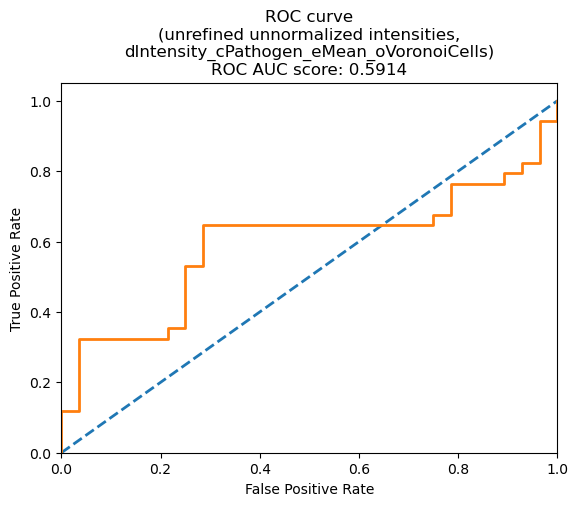

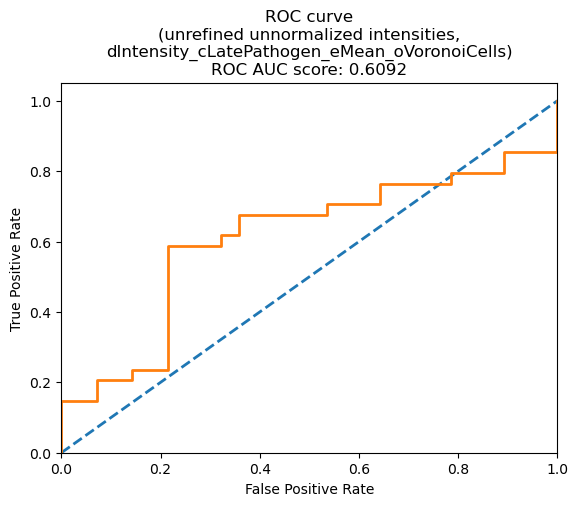

In [39]:
# Previous investigations have shown that for both early and late
# intensities, the most stable measurement type, i.e. the one exhibiting
# the least variation across all controls, is VoronoiCells
generate_ROC_curve(
    min_max_normalized_raw_intensities_df,
    prot_label_df,
    [
        "dIntensity_cPathogen_eMean_oVoronoiCells",
        "dIntensity_cLatePathogen_eMean_oVoronoiCells"
    ],
    "unrefined unnormalized intensities",
    os.path.join(roc_curve_dir_name, unrefined_ints_roc_curve_dir)
)

#### Generating ROC Curves for Refined Unnormalized Intensity Values

In [141]:
# Create a directory to store the ROC curves in
# Inside that directory, create one subdirectory for refinement via
# maximum, mean, median and sum each
refined_unnorm_ints_roc_curve_dir = "refined_unnormalized_intensity_values"

subdir_list = [
    "max_refinement",
    "mean_refinement",
    "median_refinement",
    "sum_refinement"
]

for subdir in subdir_list:
    subdir_path = os.path.join(
        roc_curve_dir_name, refined_unnorm_ints_roc_curve_dir, subdir
    )
    if not os.path.exists(subdir_path):
        os.makedirs(subdir_path)

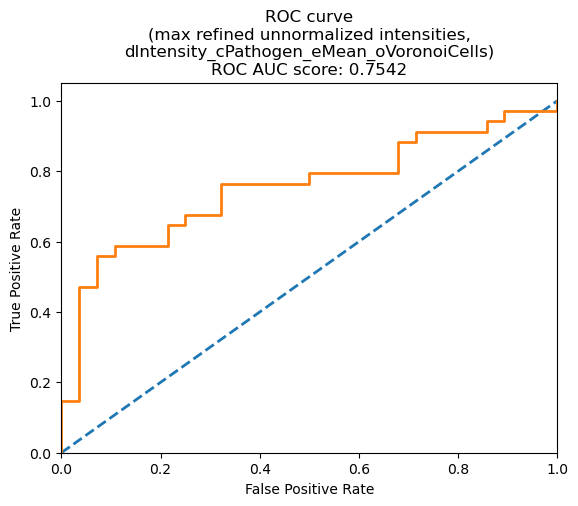

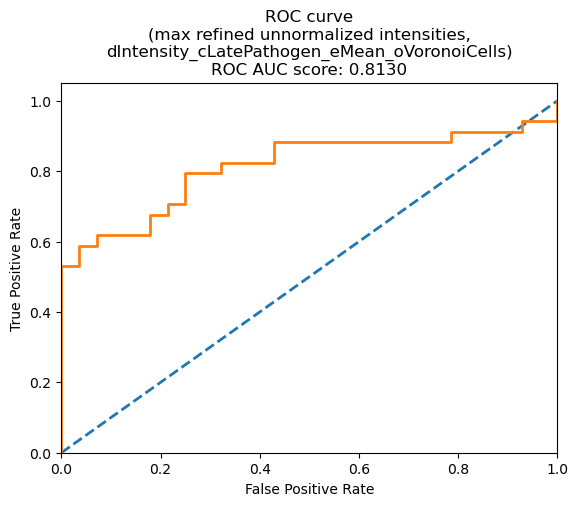

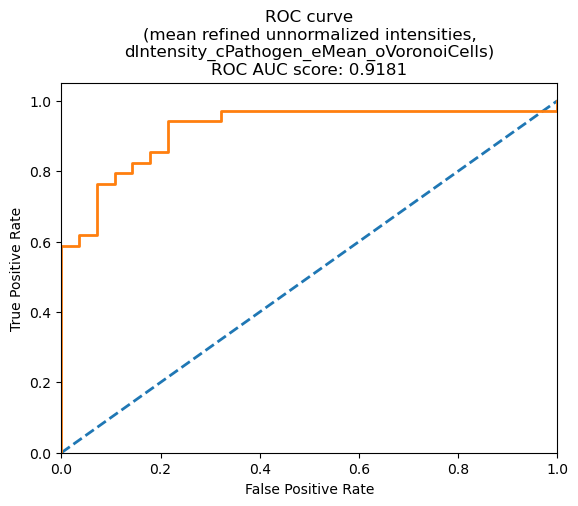

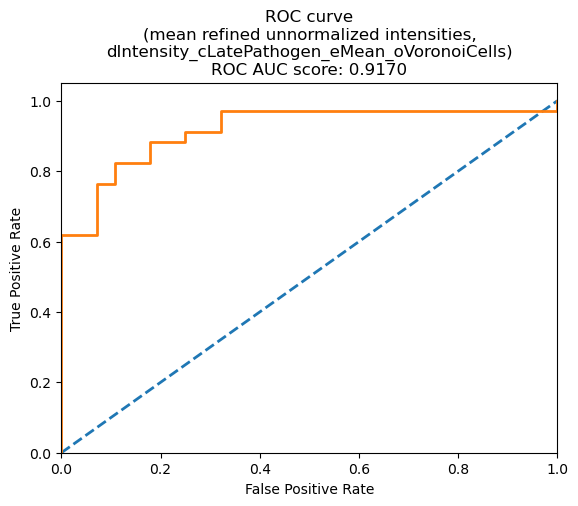

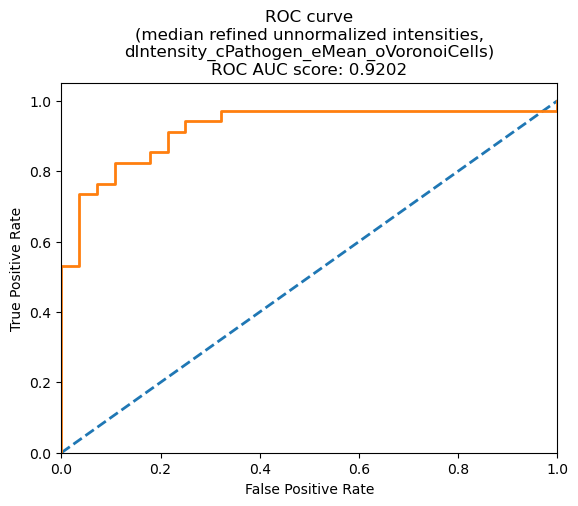

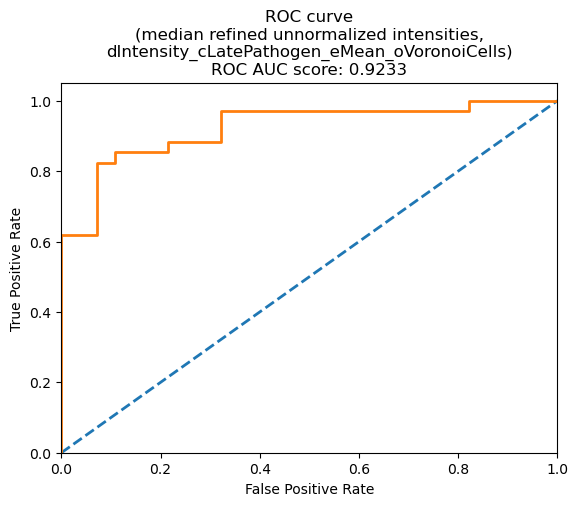

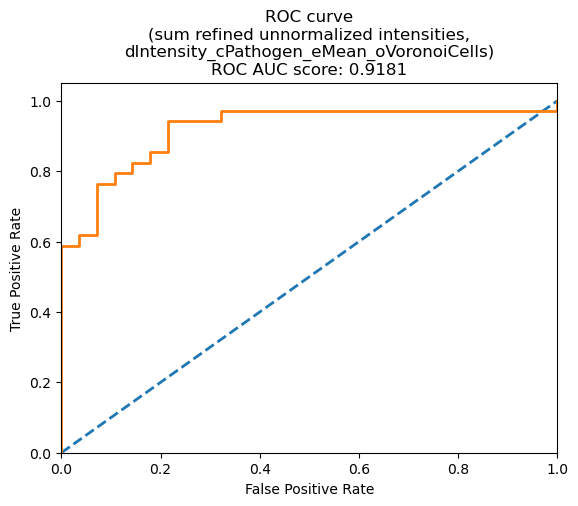

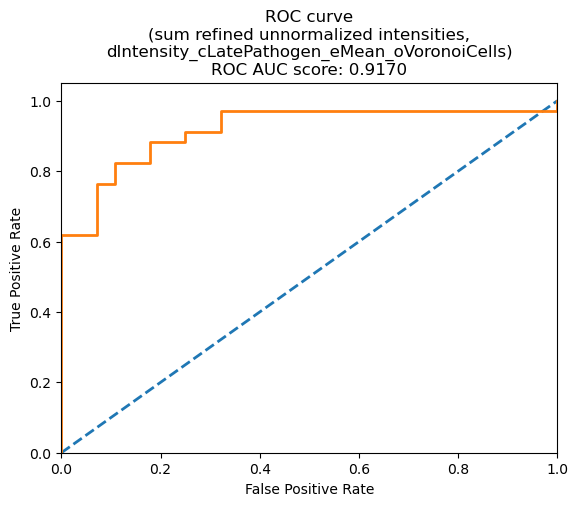

In [142]:
# Load the TSV files storing the intensities into DataFrames
# Remember that intensity refinement has been conducted using different
# statistics, which are the maximum, the mean, the median as well as the
# sum of the predicted PPI probabilities
# Thus, ROC curve generation has to be performed four times
refinement_modes = ["max", "mean", "median", "sum"]

refined_unnorm_ints_df_list = []

for mode in refinement_modes:
    current_df = pd.read_csv(
        os.path.join(
            refined_int_dir_name, f"unnorm_intensities_{mode}_refined.tsv"
        ),
        sep="\t",
        index_col=["Name", "UniProt_IDs"]
    )
    refined_unnorm_ints_df_list.append(current_df)

for mode, intensity_df in zip(refinement_modes, refined_unnorm_ints_df_list):
    generate_ROC_curve(
        intensity_df,
        prot_label_df,
        [
            "dIntensity_cPathogen_eMean_oVoronoiCells",
            "dIntensity_cLatePathogen_eMean_oVoronoiCells"
        ],
        f"{mode} refined unnormalized intensities",
        os.path.join(
            roc_curve_dir_name,
            refined_unnorm_ints_roc_curve_dir,
            f"{mode}_refinement"
        )
    )

#### Generating ROC Curves for Refined IQM-Normalized Intensity Values

In [42]:
# Load the TSV files storing the intensities into DataFrames
# Just as with the refined unnormalized intensities, the refinement has
# been conducted using the same four statistics
# Thus, ROC curve generation has to be performed four times
refinement_modes = ["max", "mean", "median", "sum"]

refined_norm_ints_df_list = []

for mode in refinement_modes:
    current_df = pd.read_csv(
        os.path.join(
            refined_int_dir_name,
            f"IQM-normalized_intensities_{mode}_refined.tsv"
        ),
        sep="\t",
        index_col=["Name", "UniProt_IDs"]
    )
    refined_norm_ints_df_list.append(current_df)

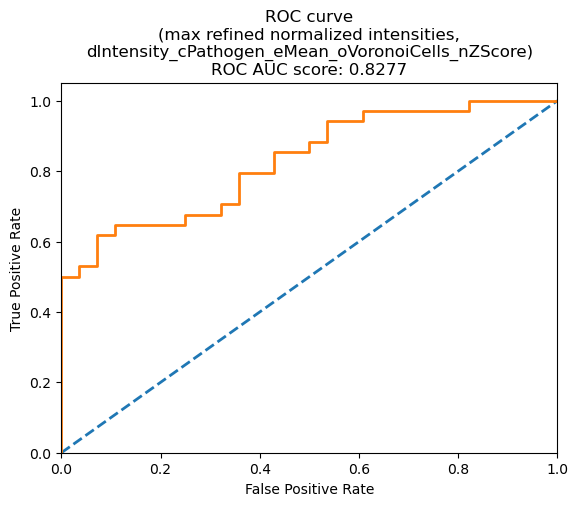

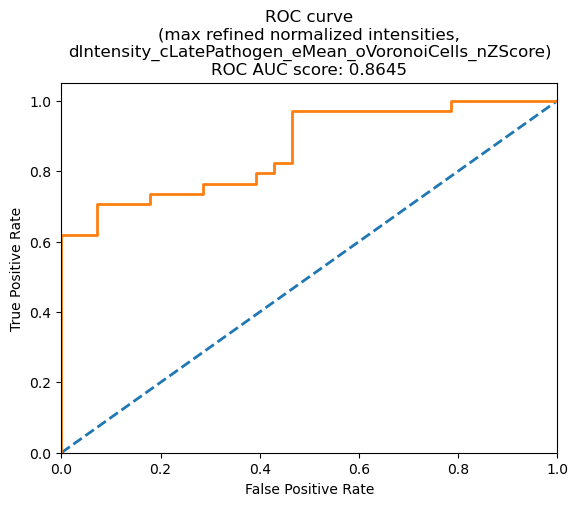

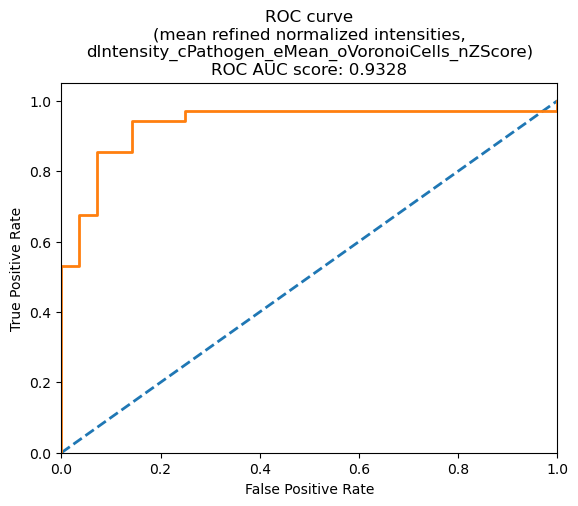

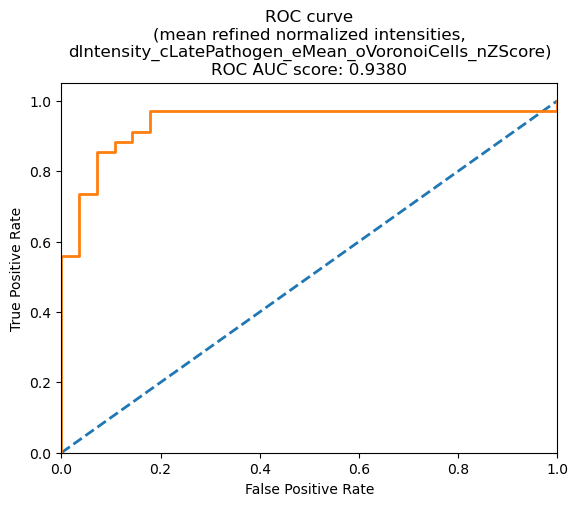

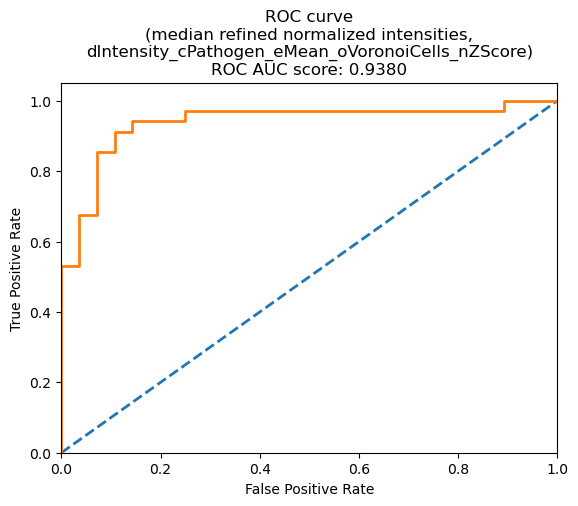

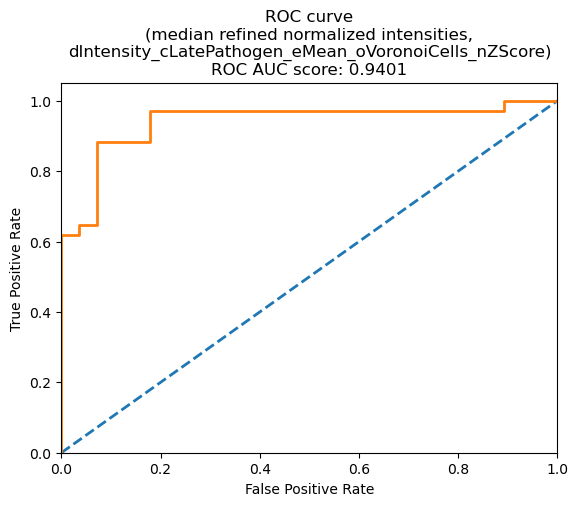

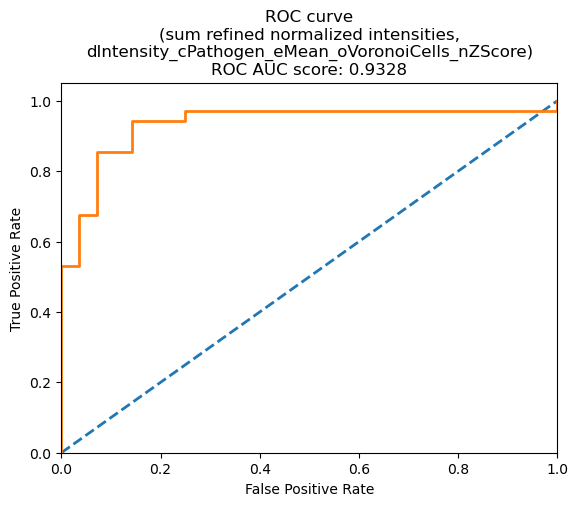

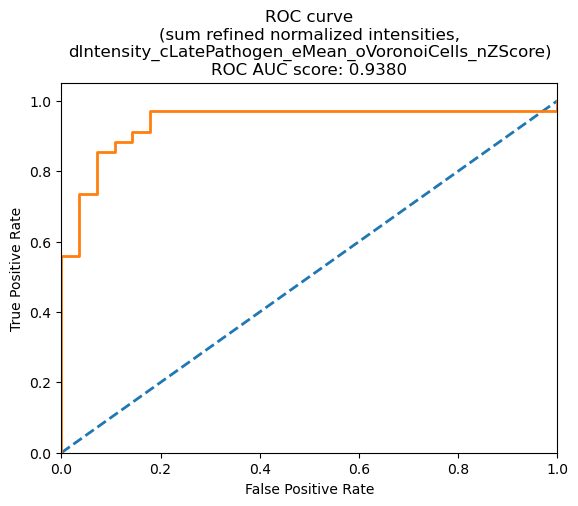

In [55]:
# Now, in a for loop, jointly create subdirectories and generate the ROC
# curves
refined_norm_ints_roc_curve_dir = "refined_normalized_intensity_values"

auc_score_and_curve_df_lists = []

for mode, intensity_df in zip(refinement_modes, refined_norm_ints_df_list):
    # Subdirectory creation
    subdir_path = os.path.join(
        roc_curve_dir_name,
        refined_norm_ints_roc_curve_dir,
        f"{mode}_refinement"
    )
    if not os.path.exists(subdir_path):
        os.makedirs(subdir_path)
    
    # ROC curve generation
    auc_score_and_curve_df_list = generate_ROC_curve(
        intensity_df,
        prot_label_df,
        [
            "dIntensity_cPathogen_eMean_oVoronoiCells_nZScore",
            "dIntensity_cLatePathogen_eMean_oVoronoiCells_nZScore"
        ],
        f"{mode} refined normalized intensities",
        subdir_path
    )

    auc_score_and_curve_df_lists.append(auc_score_and_curve_df_list)

In [57]:
# Now, for each refinement mode, save the curve data DataFrames to TSV
# files
for mode, list_per_mode in zip(
    refinement_modes, auc_score_and_curve_df_lists
):
    # For each refinement mode, two features have been investigated,
    # which are the early `VoronoiCells` intensity as well as the late
    # `VoronoiCells` intensity
    for feature, list_per_feature in zip(
        ("early_VoronoiCells", "late_VoronoiCells"),
        list_per_mode
    ):
        _, curve_df = list_per_feature

        tsv_path = os.path.join(
            roc_curve_dir_name,
            refined_norm_ints_roc_curve_dir,
            f"{mode}_refinement",
            f"roc_curve_data_{feature}.tsv"
        )

        curve_df.to_csv(
            tsv_path,
            sep="\t",
            index=False
        )